<a href="https://colab.research.google.com/github/Nazneen-akram/NED_ML_Batch3/blob/main/VGG16_model(FeatureExtraction_FineTune).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Listing 5.16 Instantiating the VGG16 convolutional base

In [1]:
import tensorflow as tf
tf.test.is_built_with_cuda()
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [2]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150,150,3))

58889256/58889256 [==============================] - 0s 0us/step


In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

# Listing 5.17 Extracting features using the pretrained convolutional base

In [4]:
config = tf.compat.v1.ConfigProto()

config.gpu_options.allow_growth=True

sess = tf.compat.v1.Session(config=config)

In [5]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)

Num GPUs Available:  0


In [6]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
sess = tf.compat.v1.Session(config=config)

In [7]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nazneenakram","key":"08d579900181a0e53c4bac39e23b069d"}'}

In [8]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle competitions download -c dogs-vs-cats

 99% 806M/812M [00:06<00:00, 37.8MB/s]
100% 812M/812M [00:06<00:00, 128MB/s] 


In [10]:
!unzip -qq dogs-vs-cats.zip


In [11]:
!unzip -qq train.zip

In [12]:
import os, shutil, pathlib
root = '/content/train'
original_dir = pathlib.Path(root)   # has 2 subfolders cat and dog

base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

In [13]:
%%script true
fname = []
for i in range(start_index, end_index):
  filename = f"{category}.{i}.jpg"
  fname.append(filename)

In [14]:
trn = os.listdir(original_dir)
len(trn)

25000

In [15]:
!rm -rf 'cats_vs_dogs_small'
make_subset(subset_name="train",      start_index=0,    end_index=2000)
make_subset(subset_name="validation", start_index=2000, end_index=2500)
make_subset(subset_name="test",       start_index=2500,end_index=3500)

In [16]:
tf.config.experimental.set_memory_growth = True
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#base_dir = './dog_cat1/abc'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 4000 images belonging to 2 classes.
1/1 [==============================] - 3s 3s/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 3s 3s/step
Found 2000 images belonging to 2 classes.
1/1 [==============================] - 3s 3s/step


In [17]:
train_features = np.reshape(train_features, (2000, 4*4* 512))
validation_features = np.reshape(validation_features, (1000, 4*4* 512))
test_features = np.reshape(test_features, (1000, 4*4* 512))

# Listing 5.18 Defining and training the densely connected classifier

In [18]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
    loss='binary_crossentropy',
    metrics=['acc'])
history = model.fit(train_features, train_labels,
epochs=30,
batch_size=20,
validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 2s 13ms/step - loss: 0.6689 - acc: 0.7645 - val_loss: 0.6281 - val_acc: 0.6810
Epoch 2/30
100/100 [==============================] - 1s 14ms/step - loss: 0.3291 - acc: 0.8540 - val_loss: 0.2788 - val_acc: 0.8870
Epoch 3/30
100/100 [==============================] - 1s 12ms/step - loss: 0.2617 - acc: 0.8935 - val_loss: 0.2920 - val_acc: 0.8630
Epoch 4/30
100/100 [==============================] - 1s 11ms/step - loss: 0.2317 - acc: 0.9045 - val_loss: 0.3450 - val_acc: 0.8730
Epoch 5/30
100/100 [==============================] - 1s 12ms/step - loss: 0.1875 - acc: 0.9250 - val_loss: 0.2835 - val_acc: 0.8910
Epoch 6/30
100/100 [==============================] - 1s 11ms/step - loss: 0.1633 - acc: 0.9380 - val_loss: 0.2862 - val_acc: 0.8890
Epoch 7/30
100/100 [==============================] - 1s 11ms/step - loss: 0.1485 - acc: 0.9485 - val_loss: 0.3066 - val_acc: 0.8830
Epoch 8/30
100/100 [==============================] - 1s 11ms/step - 

# Listing 5.19 Plotting the results

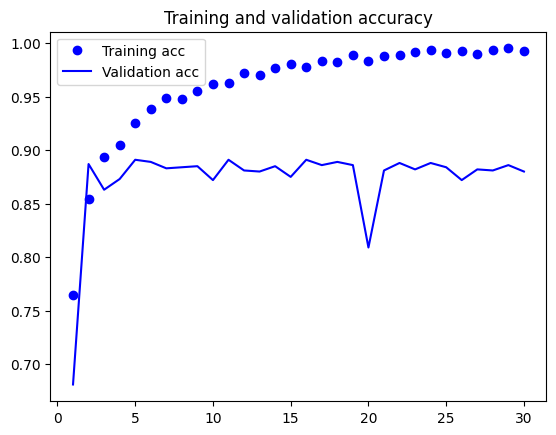

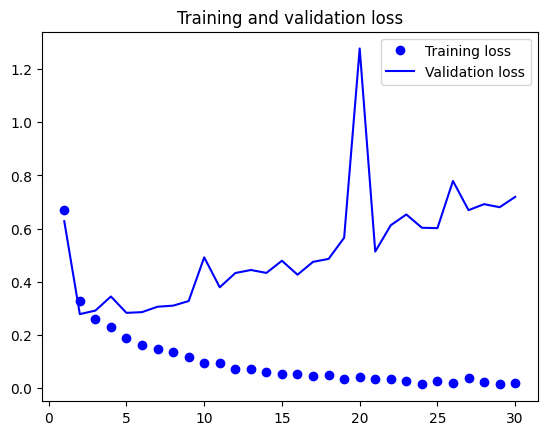

In [19]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Listing 5.20 Adding a densely connected classifier on top of the convolutional base

In [20]:
from tensorflow.keras import models
from tensorflow.keras import layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [21]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [22]:
conv_base.trainable = False

In [23]:
 print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


# Listing 5.21 Training the model end to end with a frozen convolutional base

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')
model.compile(loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=['acc'])
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Epoch 1/30


<ipython-input-24-524c67be24d4>:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


100/100 [==============================] - 493s 5s/step - loss: 0.7357 - acc: 0.7070 - val_loss: 0.3310 - val_acc: 0.8460
Epoch 2/30
100/100 [==============================] - 533s 5s/step - loss: 0.4501 - acc: 0.7845 - val_loss: 0.2879 - val_acc: 0.8660
Epoch 3/30
100/100 [==============================] - 495s 5s/step - loss: 0.4523 - acc: 0.7815 - val_loss: 0.3309 - val_acc: 0.8550
Epoch 4/30
100/100 [==============================] - 494s 5s/step - loss: 0.3864 - acc: 0.8170 - val_loss: 0.2678 - val_acc: 0.8790
Epoch 5/30
100/100 [==============================] - 532s 5s/step - loss: 0.3998 - acc: 0.8210 - val_loss: 0.3122 - val_acc: 0.8590
Epoch 6/30
100/100 [==============================] - 533s 5s/step - loss: 0.3823 - acc: 0.8260 - val_loss: 0.2743 - val_acc: 0.8760
Epoch 7/30
100/100 [==============================] - 533s 5s/step - loss: 0.3687 - acc: 0.8300 - val_loss: 0.2534 - val_acc: 0.8870
Epoch 8/30
100/100 [==============================] - 533s 5s/step - loss: 0.344

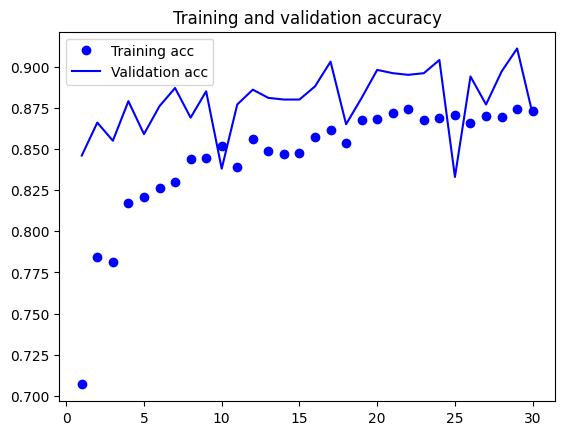

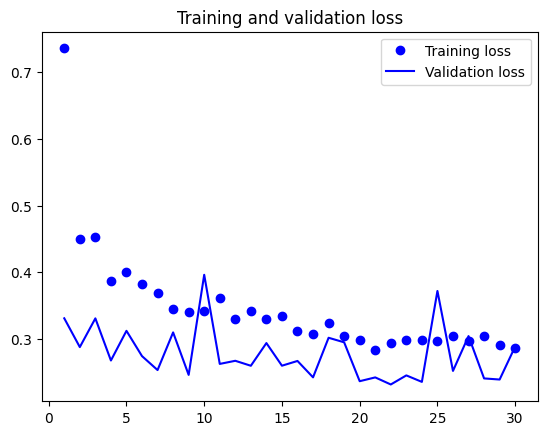

In [25]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# As a reminder, this is what your convolutional base looks like:

In [26]:
 conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

# Listing 5.22 Freezing all layers up to a specific on

In [ ]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# Listing 5.23 Fine-tuning the model

In [ ]:
model.compile(loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-5),
    metrics=['acc'])
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Listing 5.24 Smoothing the plots

In [ ]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
plt.plot(epochs,
    smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
    smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,
    smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
    smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)